In [9]:
# convert a pb file to tansorboard event
import tensorflow as tf
import sys
from tensorflow.python.platform import gfile

from tensorflow.core.protobuf import saved_model_pb2
from tensorflow.python.util import compat
export_path = 'dataset/export_output/1559608865'


In [10]:
with tf.Session() as sess:
    with gfile.FastGFile(export_path+'/saved_model.pb', 'rb') as f:
        data = compat.as_bytes(f.read())
        sm = saved_model_pb2.SavedModel()
        sm.ParseFromString(data)
        if 1 != len(sm.meta_graphs):
            print('More than one graph found. Not sure which to write')
            sys.exit(1)
        g_in = tf.import_graph_def(sm.meta_graphs[0].graph_def)
    LOGDIR='dataset/export_output/1559608865/logs'
    train_writer = tf.summary.FileWriter(LOGDIR)
    train_writer.add_graph(sess.graph)


Instructions for updating:
Use tf.gfile.GFile.


In [11]:

def load_pb(path_to_pb):
    with tf.gfile.GFile(path_to_pb, "rb") as f:
        data = compat.as_bytes(f.read())
        sm = saved_model_pb2.SavedModel()
        sm.ParseFromString(data)
        if 1 != len(sm.meta_graphs):
            print('More than one graph found. Not sure which to write')
            sys.exit(1)
        g_in = tf.import_graph_def(sm.meta_graphs[0].graph_def)
        return sess.graph

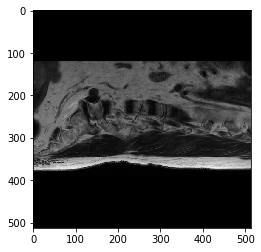

In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('dataset/VOCdevkit/VOC2012/images/000000.jpg')
image = cv2.resize(image, (513, 513))
plt.imshow(image)
plt.show()
image = image.reshape(1, 513, 513, 3)


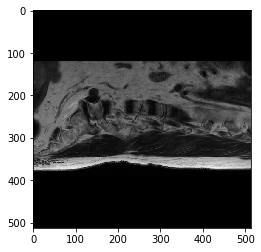

In [13]:
signature_key = 'preds'
input_key = 'image'
output_key = 'classes'
with tf.Session() as sess:
    meta_graph_def = tf.saved_model.loader.load(sess, ["serve"], export_path)
    signature = meta_graph_def.signature_def
    input_tensor_name = signature[signature_key].inputs[input_key].name
    output_tensor_name = signature[signature_key].outputs[output_key].name
    input_tensor = sess.graph.get_tensor_by_name(input_tensor_name)
    output_tensor = sess.graph.get_tensor_by_name(output_tensor_name)
    pred_array = sesss.run(output_tensor, feed_dict={input_tensor:image})

# final code

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

ckpt_path = 'model/model.ckpt-262131'
image_filename = 'dataset/test/images/002462.jpg'

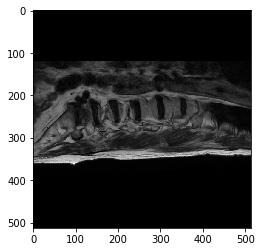

In [7]:
def preprocess_image(image_filename, means=(123.68, 116.78, 103.94)):
    image = cv2.imread(image_filename)
    image = cv2.resize(image, (513, 513))
    plt.imshow(image)
    plt.show()
#     image = np.float32(image)
    image = np.float32(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    channels = cv2.split(image)
    for i in range(len(channels)):
        channels[i] -= means[i]
    image = cv2.merge(channels)
    image = image.reshape(1, 513, 513, 3)
    return image
image = preprocess_image(image_filename)


In [8]:
saver = tf.train.import_meta_graph(ckpt_path+'.meta')
sess = tf.Session()
saver.restore(sess, ckpt_path)
graph = tf.get_default_graph()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model/model.ckpt-262131


In [9]:
in_tensor = graph.get_tensor_by_name('IteratorGetNext:0')
out_tensor_name = graph.get_tensor_by_name('softmax_tensor:0')
out_tensor = sess.run(out_tensor_name, feed_dict={in_tensor: image})
plt.imshow(np.squeeze(out_tensor[:,:,:,1] > 0.25), cmap='gray')
plt.show()

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

ckpt_path = 'model/model.ckpt-262131'
test_images_list = 'dataset/test.txt'
test_images_path = 'dataset/test'
MEANS = (123.68, 116.78, 103.94)
model_input_shape = (513, 513)


def preprocess_image(image_filename, means=MEANS):
    image = cv2.imread(image_filename)
    image = cv2.resize(image, (513, 513))
    image = np.float32(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    channels = cv2.split(image)
    for i in range(len(channels)):
        channels[i] -= means[i]
    image = cv2.merge(channels)
    image = np.expand_dims(image, axis=0)
    return image


images = []
image_list = []
with open(test_images_list) as f:
    lines = f.readlines()
    for line in lines:
        image_list.append(line.strip().split('.')[0])
        image = preprocess_image(test_images_path+'/images/'+line.strip())
        images.append(image)


saver = tf.train.import_meta_graph(ckpt_path+'.meta')

In [2]:
sess = tf.Session()
saver.restore(sess, ckpt_path)
graph = tf.get_default_graph()
in_tensor = graph.get_tensor_by_name('IteratorGetNext:0')
out_tensor_name = graph.get_tensor_by_name('softmax_tensor:0')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model/model.ckpt-262131


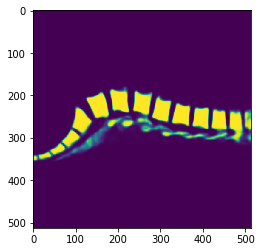

In [4]:

image = preprocess_image('dataset/train/images/000110.jpg')
image_name = 'dataset/train/merge/000110.png'
out_tensor = sess.run(out_tensor_name, feed_dict={in_tensor: image})
out_image = np.squeeze(out_tensor[:, :, :, 1])
plt.imsave(image_name, out_image, cmap='gray')
plt.imshow(np.squeeze(out_image))
plt.show()

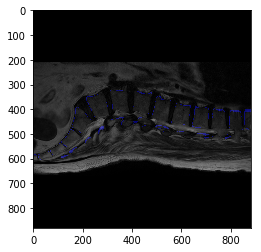

In [33]:
image_name = 'dataset/train/images/000110.jpg'
mask_name = 'dataset/train/classes/000110.png'
merge_name = 'dataset/train/merge/000110.png'

image_pro = preprocess_image(image_name)
out_tensor = sess.run(out_tensor_name, feed_dict={in_tensor: image_pro})
mask_pred = np.squeeze(out_tensor[:, :, :, 1])


image_org = cv2.imread(image_name)
mask_org = cv2.resize(cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE), image_org.shape[:-1])
mask_pred = cv2.resize(np.uint8(mask_pred>0.4), image_org.shape[:-1])


mask = np.zeros(image_org.shape, dtype=np.uint8)
mask[:, :, 0] = mask_org * 0 + mask_pred * 0
mask[:, :, 1] = mask_org * 0 + mask_pred * 0
mask[:, :, 2] = np.abs(mask_org - mask_pred) * 255
merge_image = np.uint8(image_org * 0.6 + mask * 0.4)
plt.imsave(merge_name, merge_image)
plt.imshow(merge_image)
plt.show()

192.0


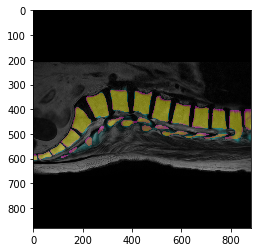

In [9]:
import os
import numpy as np
import nibabel as nib
from nibabel.testing import data_path
from skimage import io
import matplotlib.pyplot as plt


re_con = 'dataset/train/nii_reconstruct/reconstructed_Case1.nii.gz'
groundtruth = 'dataset/train/groundtruth/mask_case1.nii'
re_con_img = nib.load(re_con).get_data()
gro_img = nib.load(groundtruth).get_data()

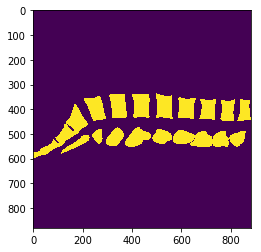

In [17]:
plt.figure(1)
plt.imshow(re_con_img[:, :, 5])
plt.figure(2)
plt.imshow(gro_img[:, :, 5])
plt.show()

True